# How and Why Does Layer Normalization Work? 

Layer normalization was first introduced in the eponymous paper Layer Normalization by Ba et al. (2016). It was intended to be a batch normalization replacement for training recurrent networks. This technique introduced a per-example normalization, providing similar improvements to the stability of activations and gradients in recurrent neural networks that batch normalization provided for fully connected and convolutional networks.

In a previous post (here), I attempted to explain why batch normalization is useful for training deep networks. However, it is not preferred for training sequence models like transformers. This is due to a few different reasons:

* The assumption behind my batch normalization implementation was that that each feature was drawn from an independent normal distribution with its own mean and variance. This worked well for a fully connected network trained on MNIST data (CNNs can get a bit more complicated). 

* Token representations are learned contextually i.e. a token embedding is a function of tokens that co-occur in the sequence. For example, the representation for bank in the sentence "I went to the bank" would be different from the one in "The bank of the river is muddy". Remember that batch normalization is implemented by normalizing each feature across a mini-batch. This is useful only when the features can be safely assumed to be i.i.d (independent and identically distributed). This is not the case for sequential data due to dependencies across tokens within a single example.




In [1]:
import jax
import flax.nnx as nnx

from jaxpt.models import GPT, GPTConfig

In [2]:
import warnings

print("JAX version:", jax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)


requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")



JAX version: 0.5.2
Available devices: 1


/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/ipykernel_36101/1635961474.py:14: UserWarning: not using gpu. Using cpu
  warnings.warn(f"not using {requested_device}. Using {device}")


In [3]:
key = jax.random.key(1338)
rngs = nnx.Rngs(key)
config = GPTConfig(block_size=128, n_layer=4, n_head=4, n_embed=192)
baseline = GPT(config=config, rngs=rngs)
graphdef, state = nnx.split(baseline)
nnx.display(state)

In [4]:
class Dummy(nnx.Module):
    def __call__(self, x):
        return x


key = jax.random.key(1337)
rngs = nnx.Rngs(key)
config = GPTConfig(block_size=128, n_layer=4, n_head=4, n_embed=192)
candidate = GPT(config=config, rngs=rngs)
for h in candidate.h:
    h.ln_1 = Dummy()
    h.ln_2 = Dummy()
candidate.ln_f = Dummy()
graphdef, state = nnx.split(candidate)
nnx.display(state)

In [5]:
from dataclasses import dataclass

import jax.numpy as jnp
import optax

@dataclass
class TrainerConfig:
  num_tokens_per_batch=2**11
  mB=16
  T=128
  max_steps=100
  max_lr=6e-4
  min_lr=6e-5
  max_grad_norm=1.0
  warmup_steps=10
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient

trconf = TrainerConfig()


def warmup_with_cosine_decay_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    coeff = 0.5 * (1 + jnp.cos(jnp.pi * (step - trconf.warmup_steps) / (trconf.max_steps - trconf.warmup_steps)))
    cosine_lr =  trconf.min_lr + coeff * (trconf.max_lr - trconf.min_lr)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < trconf.max_steps, cosine_lr, trconf.min_lr))

_, baseline_params, _ = nnx.split(baseline, nnx.Param, nnx.Variable)
baseline_weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, baseline_params)
baseline_tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(warmup_with_cosine_decay_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=baseline_weight_decay_mask)
)
baseline_optimizer = nnx.Optimizer(baseline, baseline_tx)

_, candidate_params, _ = nnx.split(candidate, nnx.Param, nnx.Variable)
candidate_weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, candidate_params)
candidate_tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(warmup_with_cosine_decay_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=candidate_weight_decay_mask)
)
candidate_optimizer = nnx.Optimizer(candidate, candidate_tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

baseline_weight_decay_param_count = jax.tree_util.tree_map(f, baseline_weight_decay_mask, baseline_params)
baseline_weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, baseline_weight_decay_param_count, 0)

candidate_weight_decay_param_count = jax.tree_util.tree_map(f, candidate_weight_decay_mask, candidate_params)
candidate_weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, candidate_weight_decay_param_count, 0)


print(f"baseline weight decay param count: {baseline_weight_decay_param_count:,}")
print(f"candidate weight decay param count: {candidate_weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps}")


baseline weight decay param count: 11,452,416
candidate weight decay param count: 11,452,416
tokens/batch: 2,048
block size: 128
sub-batch size: 16
no. gradient accumulation steps: 1
effective batch size per device:  16
effective batch size: 16
max steps: 100


In [6]:
from pathlib import Path

from jaxpt.dataloaders import DataLoader

dataset = "panchatantra-ryder"
dataset_path = Path().absolute().parent.parent / 'jaxpt' / "datasets" / dataset / "processed"
train_dl = DataLoader(dirpath=dataset_path, batch_size=trconf.mB, block_size=trconf.T, device_rank=num_devices, label="train")


dataloader initialized:
------------------------
label:          train
shards:         1
shard size:     146,776
batch size:     16
block size:     128
device rank:    1
------------------------


In [7]:
from jaxpt.train import parallel_train_step

baseline_losses, candidate_losses = [], []
for step in range(trconf.max_steps):
    batch, targets = train_dl()
    baseline_avg_loss, _  = parallel_train_step(baseline, baseline_optimizer, batch, targets)
    candidate_avg_loss, _ = parallel_train_step(candidate, candidate_optimizer, batch, targets)
    baseline_losses.append(baseline_avg_loss[0])
    candidate_losses.append(candidate_avg_loss[0])
    print(f"step: {step}, baseline loss: {baseline_avg_loss}, candidate_loss: {candidate_avg_loss}")


step: 0, baseline loss: [10.841708], candidate_loss: [10.82425]
step: 1, baseline loss: [10.629961], candidate_loss: [10.822067]
step: 2, baseline loss: [10.355402], candidate_loss: [10.818748]
step: 3, baseline loss: [10.285589], candidate_loss: [10.81872]
step: 4, baseline loss: [10.233845], candidate_loss: [10.81715]
step: 5, baseline loss: [10.130755], candidate_loss: [10.81115]
step: 6, baseline loss: [10.003091], candidate_loss: [10.803385]
step: 7, baseline loss: [9.858101], candidate_loss: [10.787918]
step: 8, baseline loss: [9.81995], candidate_loss: [10.763973]
step: 9, baseline loss: [9.687083], candidate_loss: [10.70852]
step: 10, baseline loss: [9.595406], candidate_loss: [10.601372]
step: 11, baseline loss: [9.368], candidate_loss: [10.310646]
step: 12, baseline loss: [9.260825], candidate_loss: [9.710981]
step: 13, baseline loss: [9.213768], candidate_loss: [8.458849]
step: 14, baseline loss: [9.143789], candidate_loss: [11.383751]
step: 15, baseline loss: [8.89413], can

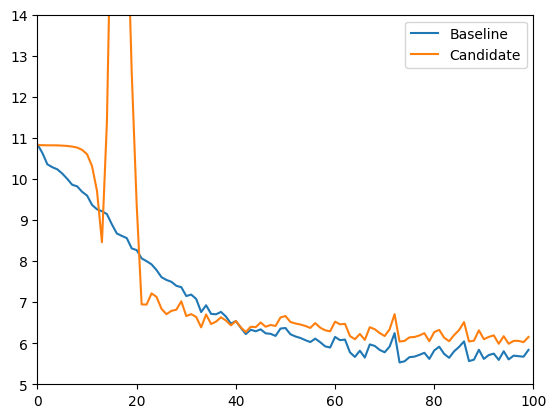

In [8]:

import matplotlib.pyplot as plt 
plt.plot(baseline_losses, label="Baseline")
plt.plot(candidate_losses, label="Candidate")
plt.ylim(5, 14)
plt.xlim(0, 100)
plt.legend()
plt.show()